In [1]:
from dataset_generator import generate_random_image, showImagesHorizontally, generate_params
import random

from tqdm.auto import tqdm

import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import numpy as np
from collections import defaultdict


seed = 42
np.random.seed(seed)
random.seed(seed)
transform = ToTensor()
n_samples = 1_000
data = [transform(generate_random_image(**generate_params)) for _ in range(n_samples)]



class GumbelCoding2d(nn.Module):
    def __init__(self, in_features: int, num_codebooks: int, codebook_size: int, **kwargs):
        super().__init__()
        self.num_codebooks, self.codebook_size = num_codebooks, codebook_size
        self.proj = nn.Conv2d(in_features, num_codebooks * codebook_size, **kwargs)
        
    def forward(self, x, **kwargs):
        batch, _, height, width = x.shape
        logits = self.proj(x).view(batch, self.num_codebooks, self.codebook_size, height, width)
        codes = F.gumbel_softmax(logits, dim=-3, **kwargs)  # gumbel over codebook size
        return codes, F.log_softmax(logits, dim=-3)

    
# def iterate_minibatches(*tensors, batch_size, shuffle=True, epochs=1,
#                         allow_incomplete=True, callback=lambda x:x):
#     indices = np.arange(len(tensors[0]))
#     upper_bound = int((np.ceil if allow_incomplete else np.floor) (len(indices) / batch_size)) * batch_size
#     epoch = 0
#     while True:
#         if shuffle:
#             np.random.shuffle(indices)
#         for batch_start in callback(range(0, upper_bound, batch_size)):
#             batch_ix = indices[batch_start: batch_start + batch_size]
#             batch = [tensor[batch_ix] for tensor in tensors]
#             yield batch if len(tensors) > 1 else batch[0]
#         epoch += 1
#         if epoch >= epochs:
#             break


class Foo(nn.Module):
    def __init__(self, num_channels: int, **kwargs):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 32, 3), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3), nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(64, 128, 3), nn.BatchNorm2d(128), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(128, 256, 3), nn.BatchNorm2d(256), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(256, 512, 3), nn.BatchNorm2d(512), nn.ReLU(),
        )
        
        self.coding = GumbelCoding2d(in_features=512, **kwargs)
        
        decoder_input_channels = self.coding.num_codebooks * self.coding.codebook_size
        self.decoder = nn.Sequential(
            nn.Conv2d(decoder_input_channels, 512, 3, padding=2), nn.BatchNorm2d(512), nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(512, 256, 3, padding=2), nn.BatchNorm2d(256), nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(256, 128, 3, padding=2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2), nn.Conv2d(128, 64, 3, padding=2), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=2), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, num_channels, 1)
        )
        
    def forward(self, x, **kwargs):
        codes, logp = self.coding(self.encoder(x), **kwargs)
        return self.decoder(codes.flatten(1, 2)), codes, logp



def get_batch(batch_size, transform, **generate_params):
    return torch.stack([transform(generate_random_image(**generate_params))
                        for _ in range(batch_size)])



# gumbel softmax params
tau = 0.1
hard = True

# regularizers
target_density = 0.1  # kl reg will aim to leave this fraction of logits
beta_max = 0.1  # kl strength from beta vae
beta_warmup_epochs = 200
cv_reg = 0.1  # load balancing strength from shazeer
eps=1e-6

# training
batch_size = 32
device = 'cpu'
# device = 'cuda:0'

num_channels = 3
num_codebooks = 1
codebook_size = 256 * 64
kernel_size = 1

model = Foo(num_channels=num_channels, num_codebooks=num_codebooks, codebook_size=codebook_size, kernel_size=kernel_size)
opt = torch.optim.Adam(model.parameters(), 1e-4)


model = model.to(device)
# data = MNIST(root='.', train=True, download=True).data.float().view(-1, 1, 28, 28) / 255
# epoch_i = 0
# transform = ToTensor()

[nltk_data] Downloading package words to /home/alex/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
import matplotlib.pyplot as plt

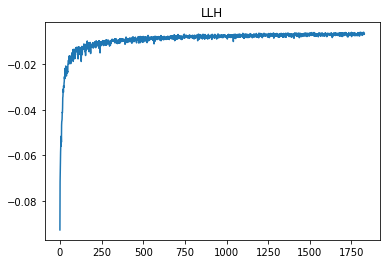

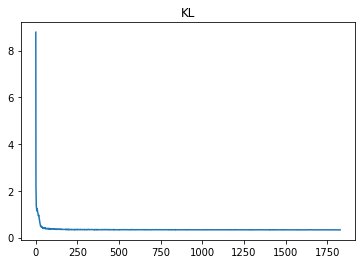

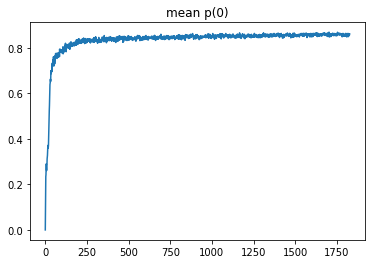

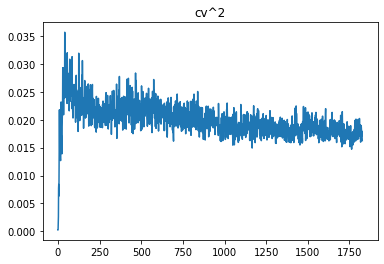

In [3]:
snapshot = torch.load('snapshots/overfit_1codebook/snapshot.tar', map_location='cpu')
metrics = snapshot['metrics']
model.load_state_dict(snapshot['model'])

for key, value in metrics.items():
    plt.subplots()
    plt.title(key)
    plt.plot(value)
plt.show()

In [6]:
# x = get_batch(8, transform=transform, **generate_params)
x = torch.stack(data[:5])
with torch.inference_mode():
    x_rec, codes, logp = model(x, tau=tau, hard=hard)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


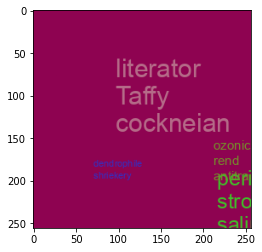

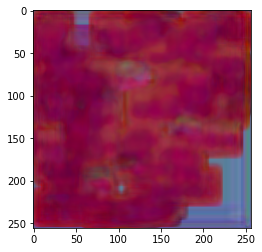

In [7]:
def imshow(image):
    plt.imshow(image.detach().cpu().permute(1, 2, 0).numpy())

idx = 1
plt.subplots()
imshow(x[idx])
plt.subplots()
imshow(x_rec[idx])

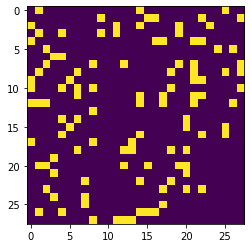

In [8]:
plt.imshow((codes.argmax(dim=-3)!=0).sum(dim=1).cpu().numpy()[idx].reshape(28, 28))